# Schedule TPC-DS 1 Descriptor

This notebook contains work pertatining to pattern learning / identification for a database workload schedule. It contains descriptors of the available data through plot visualizations, so as to better understand which resource play a part into reflecting underlying workloads.

## Data Preprocessing

### Module Installation and Importing Libraries

In [1]:
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
tpcds='TPCDS1'

### Read data from file into Pandas Dataframes

In [3]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_sysstat_headers = prettify_header(rep_hist_sysstat_df.columns.values)

# Replace original headers with a prettified version of the same column list
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, names=rep_hist_sysstat_headers)

rep_hist_sysstat_df.drop(rep_hist_sysstat_df.index[0],inplace=True)

print("---------------------------------------------------------------------------------")
print(rep_hist_sysstat_df.head())
print("---------------------------------------------------------------------------------")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,1,2,3,5,6,7,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


---------------------------------------------------------------------------------
  SNAP_ID        DBID INSTANCE_NUMBER     STAT_ID                  STAT_NAME  \
1   43414  2634225673               1   576270482        OS CPU Qt wait time   
2   43414  2634225673               1  3982115148    Requests to/from client   
3   43414  2634225673               1  2666645286          logons cumulative   
4   43414  2634225673               1  3080465522             logons current   
5   43414  2634225673               1    85052502  opened cursors cumulative   

       VALUE    CON_DBID CON_ID         STARTUP_TIME  \
1          0  2634225673      0  2018-10-04 23:04:59   
2  286814244  2634225673      0  2018-10-04 23:04:59   
3   30013683  2634225673      0  2018-10-04 23:04:59   
4         84  2634225673      0  2018-10-04 23:04:59   
5  336849183  2634225673      0  2018-10-04 23:04:59   

          BEGIN_INTERVAL_TIME           END_INTERVAL_TIME   FLUSH_ELAPSED  \
1  2018-11-16 17:33:34.

# Dataset Description

All data sources are retrieved from Oracle defined tables/views. These sources have been specifically chosen because they accurately portray a database system under load, across a period of time. Such data sources were polled at regular intervals (60 seconds), and recorded into intermediatery tables for future data mining potential. Each statistic set corresponds to a 'SNAP_ID', which quantifies a particular resource usage at a point in time. 'SNAP_ID' delta equates to 60 seconds. In addition, relavent SQL access plans taken during the workloads execution were also captured.

Statistical calculations:
* Column Names
* Dataframe Row Counts
* Mean (were applicable)
* Standard Dev (were applicable)
* Quartile Percentile
* Min / Max

In [4]:
print('-----------------------------------------------------------')
print('Dataframe Row Count: REP HIST_SYSSTAT - ' + str(len(rep_hist_sysstat_df)))
print('-----------------------------------------------------------\n')

print('\n\nHIST_SYSSTAT:')
print(rep_hist_sysstat_df.describe())

-----------------------------------------------------------
Dataframe Row Count: REP HIST_SYSSTAT - 23360885
-----------------------------------------------------------



HIST_SYSSTAT:
         SNAP_ID        DBID  INSTANCE_NUMBER     STAT_ID  \
count   23360885    23360885         23360885    23360885   
unique     19832           2                2        2356   
top        43424  2634225673                1  2257986540   
freq        1178    23328118         23328118       19804   

                                 STAT_NAME     VALUE    CON_DBID    CON_ID  \
count                             23360885  23360885    23360885  23360885   
unique                                1178   4128971           2         2   
top     IM repopulate undo records applied         0  2634225673         0   
freq                                 19831  16634339    23328118  23328118   

               STARTUP_TIME         BEGIN_INTERVAL_TIME  \
count              23360885                    23360885   

# Dataset Extraction

The above datasets were extracted from the following user defined tables:
* REP_HIST_SYSSTAT

Each table corresponds to an Oracle defined table, whose sole function is to offload data from Oracle defined tables (which tend to have a retention period) into a user defined table. Table REP_HIST_SNAPSHOT, REP_HIST_SYSMETRIC_SUMMARY and REP_HIST_SYSSTAT can be joined through the 'SNAP_ID' column. Table REP_VSQL_PLAN can be joined to REP_HIST_SNAPSHOT through the 'SQL_ID' column.

For table REP_HIST_SYSSTAT, the oracle history table DBA_HIST_SNAPSHOT (https://docs.oracle.com/cd/B19306_01/server.102/b14237/statviews_3177.htm#REFRN23442) was joined with DBA_HIST_SYSSTAT (https://docs.oracle.com/database/121/REFRN/GUID-C94C6E6D-3FB0-4A81-A350-A1F312CDFEBB.htm#REFRN23453). This Oracle table mantains a record of historical systems statistics, including OLAP kernel statistics pertaining to snapshots (established in v$sysstat). The specific query used can be found further below.

``` sql
/*DBA_HIST_SYSSTAT*/
select dhsys.*,
       dhs.startup_time,
       dhs.begin_interval_time,
       dhs.end_interval_time,
       dhs.flush_elapsed,
       dhs.snap_level,
       dhs.error_count,
       dhs.snap_flag,
       dhs.snap_timezone
from DBA_HIST_SYSSTAT dhsys,
     dba_hist_snapshot dhs
where dhsys.snap_id = dhs.snap_id
and dhsys.dbid = dhs.dbid
and dhsys.instance_number = dhs.instance_number
and dhs.snap_id = '618';
```

# Data Visualization

The following section visualizes each dataset through a number of pictorial graphs, so as to better visualize the underlying load distribution.

In [5]:
def plot_snapshot_distribution(table=None, column=None, tpc_type=None):
    """
    Plots line graph.
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    table=table.lower()
    
    if table == 'rep_hist_snapshot':
        df = rep_hist_snapshot_df
    elif table == 'rep_hist_sysmetric_summary':
        df = rep_hist_sysmetric_summary_df
    elif table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    else:
        raise ValueError('Table Name not supported!')
    
    # Convert to float
    df['SNAP_ID'] = df['SNAP_ID'].astype(float)
    df[column]=df[column].astype(float)
    start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
    
    # Sort by order of execute time
    df = df.sort_values(by=['SNAP_ID'])
    
    # Group by SNAP_ID
    df = df.groupby(['SNAP_ID'])[column].sum()
    
    fig, ax = plt.subplots()
    df.plot(kind='line', x='SNAP_ID', y=column, ax=ax)
    plt.ylabel(column)
    plt.xlabel('SNAP ID')
    plt.title(tpc_type + ' ' + str(column) + " between " + str(start_snap) + " - " + str(end_snap))
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()

def plot_snapshot_ratios(table=None, column=None, tpc_type=None):
    """
    Plots Pie Chart
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    table=table.lower()
    
    if table == 'rep_hist_snapshot':
        df = rep_hist_snapshot_df
    elif table == 'rep_hist_sysmetric_summary':
        df = rep_hist_sysmetric_summary_df
    elif table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    elif table == 'rep_vsql_plan':
        df = rep_vsql_plan_df
    else:
        raise ValueError('Table Name not supported!')
    
    df = df.groupby([column])[column].count()
    
    # Sort by operation counts
    series = pd.Series(df.values, index=df.index, name='series')
    series.plot.pie(figsize=(6, 6))
    #plt.xticks([])
    plt.ylabel(column)
    plt.title(tpc_type + ' ' + str(column) + ' Ratio')
    plt.rcParams['figure.figsize'] = [40, 30]
    plt.legend(bbox_to_anchor=(0.95,0.95))
    plt.show()

## Table DBA_HIST_SYSSTAT

Plotting metrics from table REP_HIST_SYSSTAT (DBA_HIST_SYSSTAT), categorized by 'METRIC UNIT' into grid plots.

``` sql
/*DBA_HIST_SYSSTAT*/
select dhsys.*,
       dhs.startup_time,
       dhs.begin_interval_time,
       dhs.end_interval_time,
       dhs.flush_elapsed,
       dhs.snap_level,
       dhs.error_count,
       dhs.snap_flag,
       dhs.snap_timezone
from DBA_HIST_SYSSTAT dhsys,
     dba_hist_snapshot dhs
where dhsys.snap_id = dhs.snap_id
and dhsys.dbid = dhs.dbid
and dhsys.instance_number = dhs.instance_number
and dhs.snap_id = '618'
```

Requests to/from client


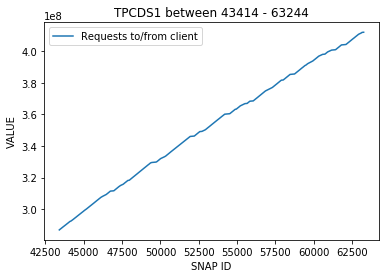

logons cumulative


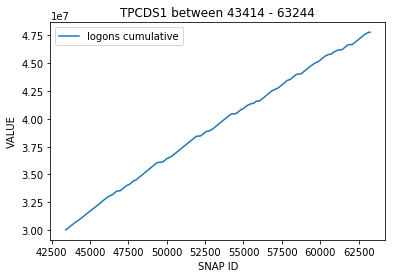

logons current


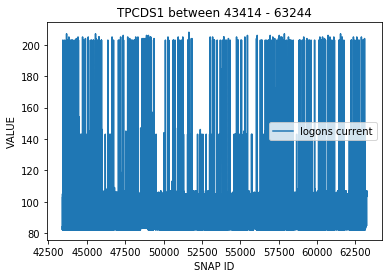

opened cursors cumulative


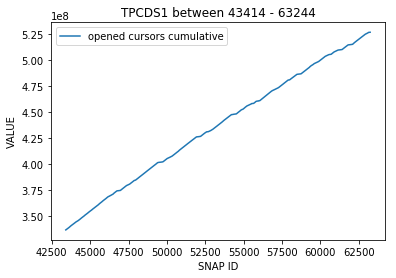

opened cursors current


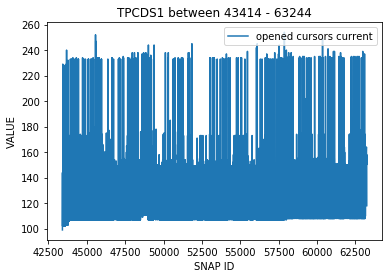

user commits


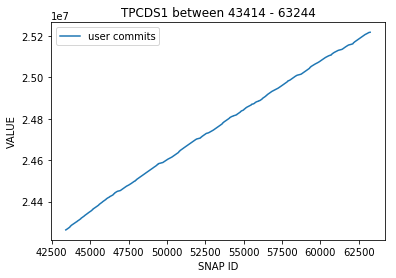

user rollbacks


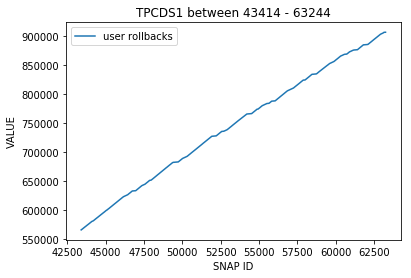

user calls


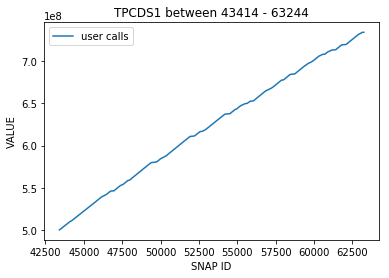

recursive calls


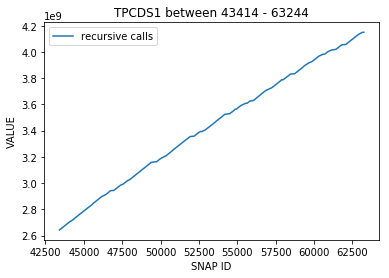

recursive cpu usage


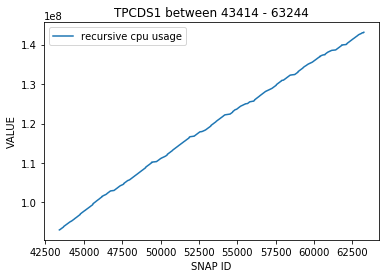

pinned cursors current


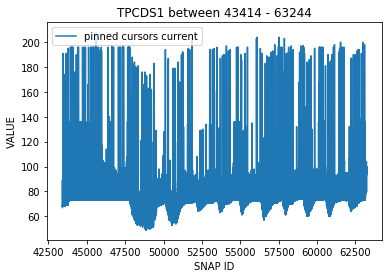

user logons cumulative


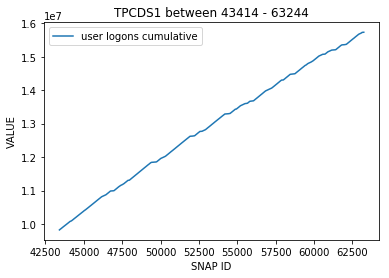

user logouts cumulative


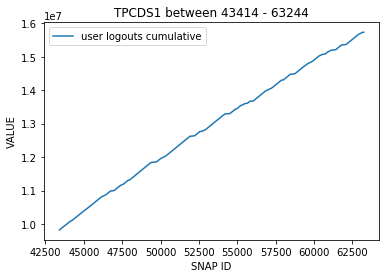

session logical reads


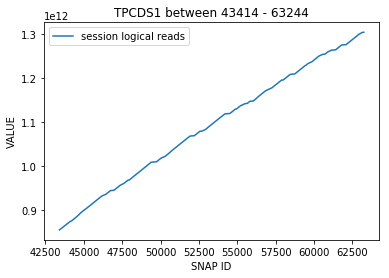

CPU used when call started


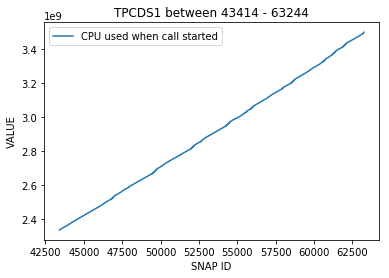

CPU used by this session


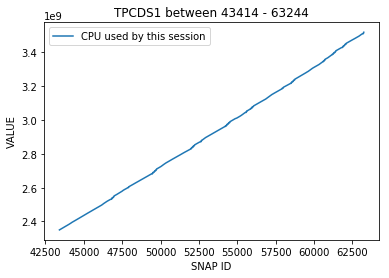

DB time


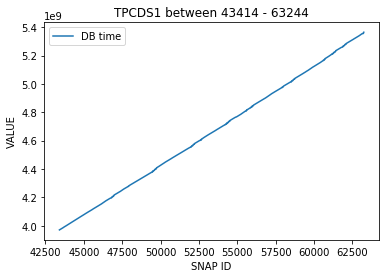

concurrency wait time


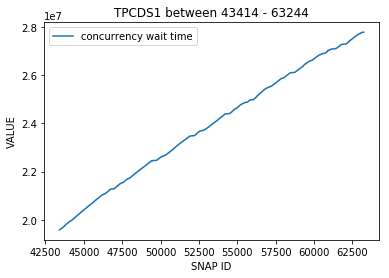

application wait time


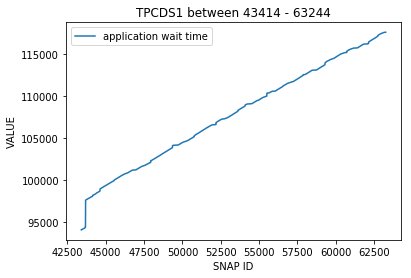

user I/O wait time


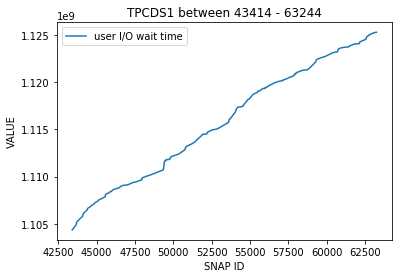

scheduler wait time


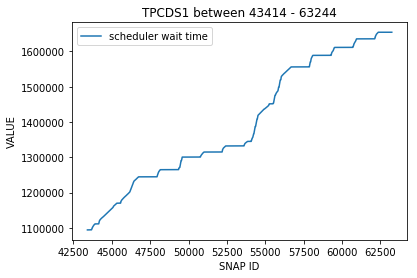

non-idle wait time


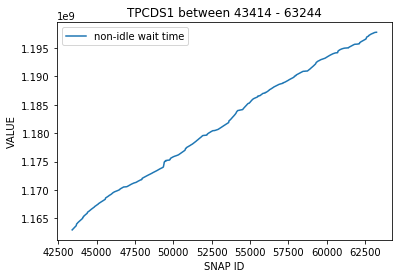

non-idle wait count


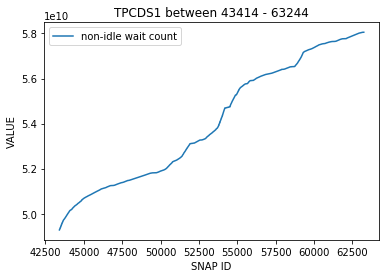

in call idle wait time


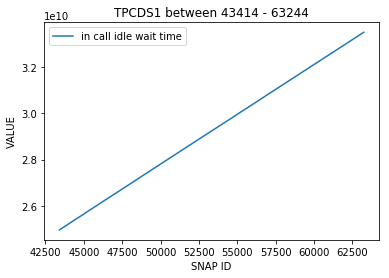

session connect time


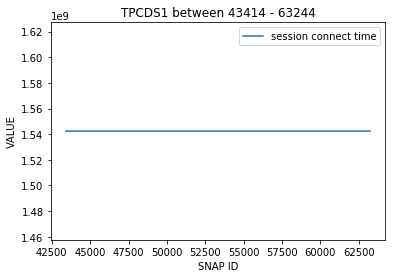

process last non-idle time


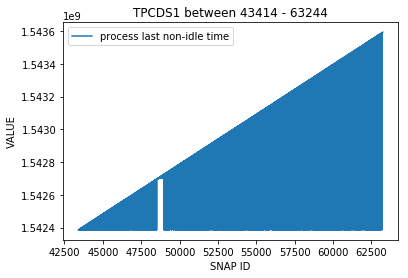

session uga memory


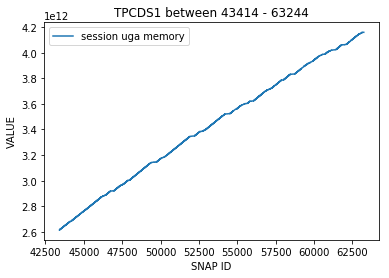

session uga memory max


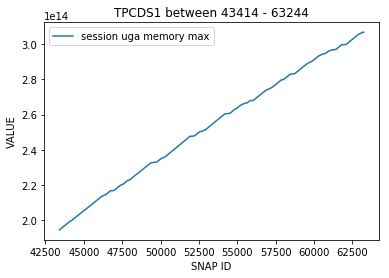

messages sent


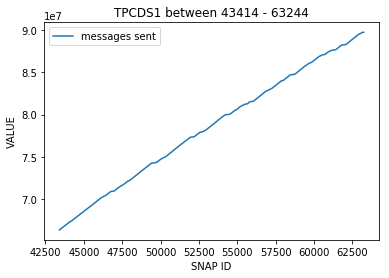

messages received


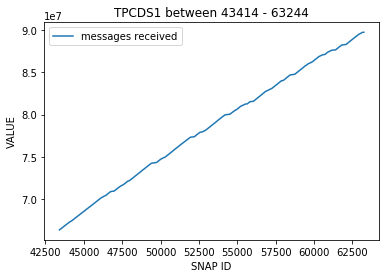

background timeouts


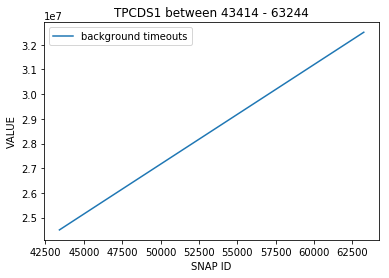

session pga memory


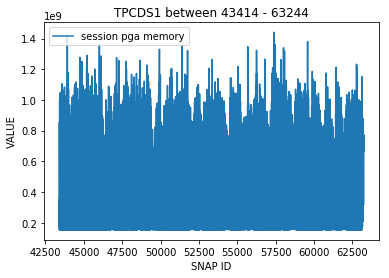

session pga memory max


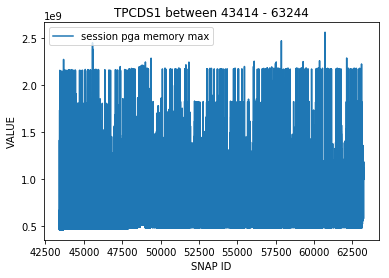

enqueue timeouts


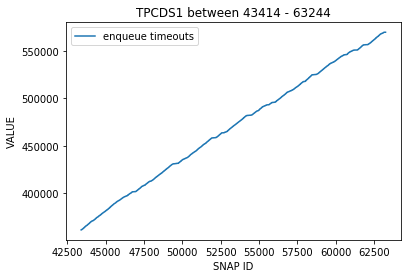

enqueue waits


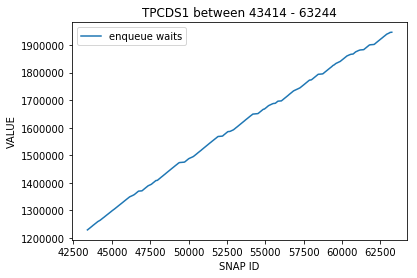

enqueue requests


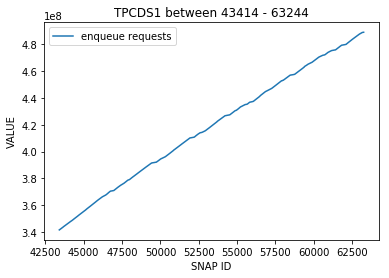

enqueue conversions


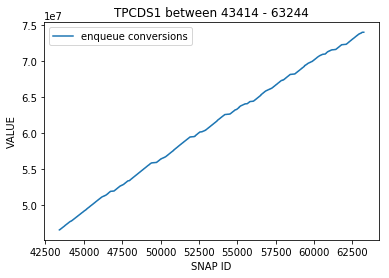

enqueue releases


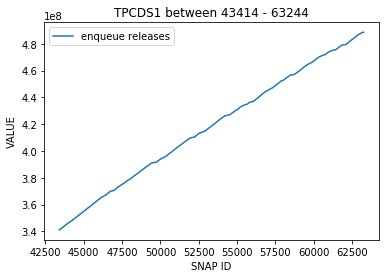

physical read total IO requests


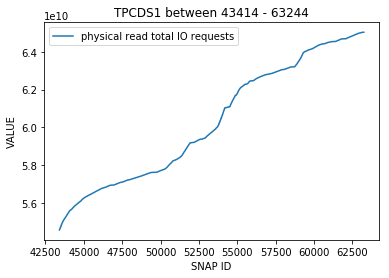

physical read total multi block requests


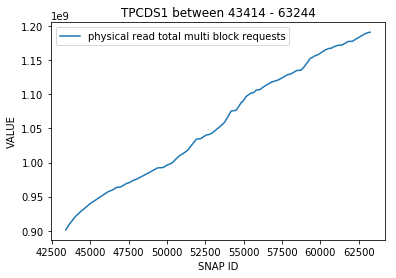

physical read total bytes


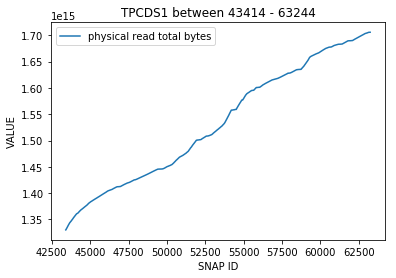

physical write total IO requests


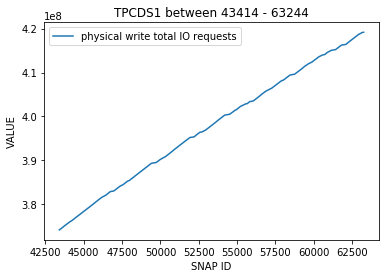

physical write total multi block requests


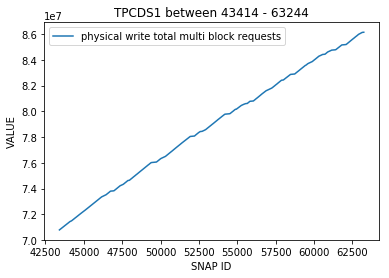

physical write total bytes


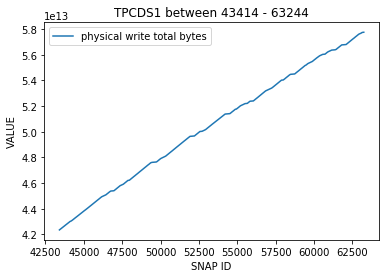

cell physical IO interconnect bytes


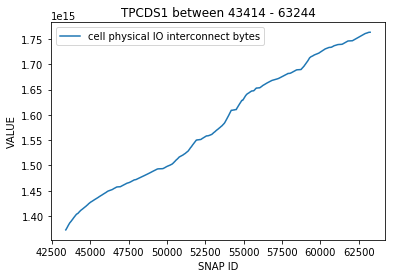

max cf enq hold time


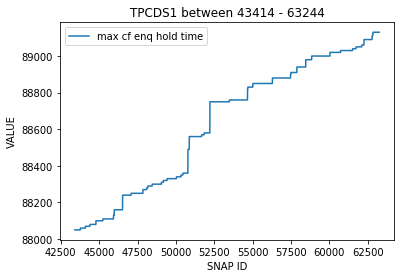

total cf enq hold time


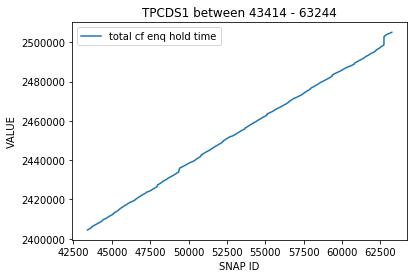

total number of cf enq holders


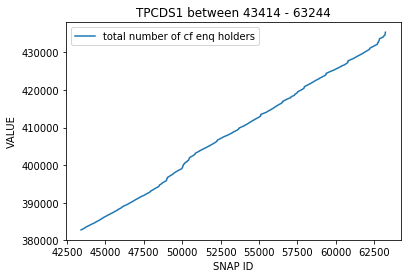

db block gets


KeyboardInterrupt: 

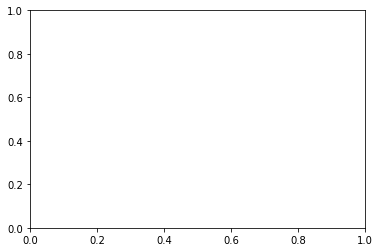

In [6]:
def check_flatline_stats(stat_name=None, filtered_df=None):
    """
    Checks whether input stat_name is considered flatline or not. Flatline stats are stat_names with constant
    values, which never change over the course of a schedule. Such flatline stats will be discarded since they 
    are not helpful.
    """
    filtered_df = filtered_df.where(filtered_df['STAT_NAME'] == stat_name).dropna(how='all')
    if int(filtered_df['VALUE']) == 0:
        return True
    else:
        return False

def get_eligable_stats(table=None, start_snap=None):
    """
    Iterates over all stats from the STAT ID column and returns stats which are not considered flatline.
    """
    if table is None:
        raise ValueError('Parameters were declared incorrectly!')
    table = table.lower()
    
    if table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    else:
        raise ValueError('Table Name not supported!') 
    
    statistic_list = []
    filtered_df = df.where(df['SNAP_ID'] == start_snap).dropna(how='all')
    for row in filtered_df.itertuples():
        if not check_flatline_stats(stat_name=row[5], filtered_df=filtered_df):
            statistic_list.append(row[5])
    
    return statistic_list

def plot_statistic_distribution(table=None, tpc_type=None):
    """
    Iterates over eligable statistics and plots them as a line graph.
    """
    if table is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    table = table.lower()
    
    if table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    else:
        raise ValueError('Table Name not supported!')
    
    # Convert to float
    df['SNAP_ID'] = df['SNAP_ID'].astype(float)
    start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
    df['VALUE'] = df['VALUE'].astype(float)
    
    for statistic in get_eligable_stats(table=table, start_snap=start_snap):
        print(statistic)
        fig, ax = plt.subplots()
        df2 = df.where(df['STAT_NAME'] == statistic).dropna(how='all')
        df2 = df2.groupby(['SNAP_ID'])['VALUE'].sum() # This line is mostly not needed since metrics are already grouped by snap_id
        ax = df2.plot(kind='line', x='SNAP_ID', y='VALUE', label=statistic, ax=ax)
        ax.legend()
        plt.title(tpc_type + " between " + str(start_snap) + " - " + str(end_snap))
        plt.ylabel('VALUE')
        plt.xlabel('SNAP ID')
        plt.show()

plot_statistic_distribution(table='rep_hist_sysstat', tpc_type=tpcds)